In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [4]:
reviews_train = load_files('../../data/aclImdb/train')
text_train, y_train = reviews_train.data, reviews_train.target

In [5]:
print(len(text_train))
print(np.bincount(y_train))

25000
[12500 12500]


In [7]:
reviews_test = load_files('../../data/aclImdb/test')
text_test, y_test = reviews_test.data, reviews_test.target
print(len(text_test))
print(np.bincount(y_test))

25000
[12500 12500]


In [8]:
cv = CountVectorizer()
cv.fit(text_train)
len(cv.vocabulary_)

74849

In [9]:
print(cv.get_feature_names()[:70])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m', '100min', '100mph', '100s', '100th', '100x', '100yards', '101', '101st', '102', '102nd', '103', '104', '1040', '1040a', '1040s', '105', '1050', '105lbs', '106', '106min']


In [10]:
X_train = cv.transform(text_train)

In [11]:
print(text_train[12345])

b"I felt this film - throughout. I waas impressed with Russell Crowe's talent in developing his relationship with Lillie, such a typical Aussie blend of softly softly approach, a bit self depreciating and very persistent. Really loved the cinematography and direction. Pace was just right and the portrayals of nearly all characters was impressive.<br /><br />Gosh, didn't Russell's talent even in 1993 shine! .. and I have yet to see Gladiator."


In [12]:
X_train[12345].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([  409,  2662,  3258,  3951,  5031,  7485,  7745,  8724, 11635,
        12480, 15743, 17670, 18044, 18303, 18568, 22718, 24199, 24536,
        27640, 28200, 30118, 31095, 32938, 32949, 33004, 35787, 38790,
        39570, 45141, 46680, 47943, 49380, 50948, 53839, 54641, 55827,
        56847, 58585, 58701, 59621, 61500, 64115, 65367, 66339, 66562,
        66703, 67125, 68811, 71159, 71854, 72196, 73342, 74216],
       dtype=int32))

In [14]:
X_test = cv.transform(text_test)

In [15]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=17)
logit.fit(X_train, y_train)

CPU times: user 1.25 s, sys: 4.32 s, total: 5.57 s
Wall time: 10.6 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=17,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [16]:
print(round(logit.score(X_train, y_train), 3))
print(round(logit.score(X_test, y_test), 3))

0.981
0.864


In [20]:
def viz_coefs(clf, feature_names, n_top_features=25):
    coef = clf.coef_.ravel()
    pos_coefs = np.argsort(coef)[-n_top_features:]
    neg_coefs = np.argsort(coef)[:n_top_features]
    inter_coefs = np.hstack([neg_coefs, pos_coefs])
    
    plt.figure(figsize=(15,5))
    colors = ['red' if c<0 else 'blue' for c in coef[inter_coefs]]
    plt.bar(np.arange(2*n_top_features), 
            coef[inter_coefs], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1+2*n_top_features), 
               feature_names[inter_coefs], rotation=60, ha='right');

In [31]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();
    

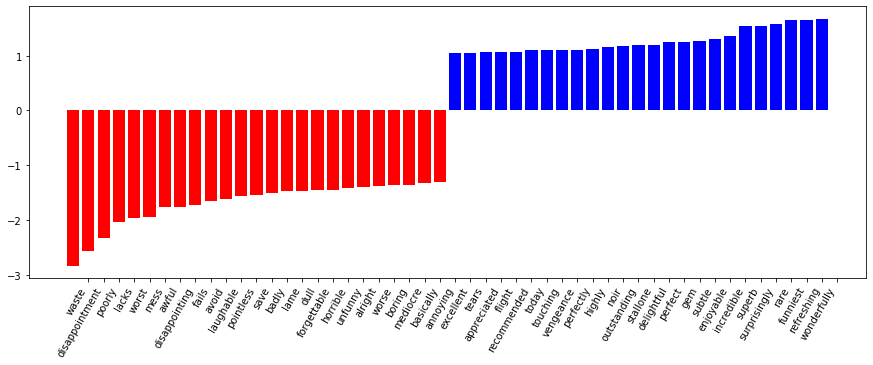

In [22]:
viz_coefs(logit, cv.get_feature_names())

In [25]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(),
                               LogisticRegression(n_jobs=-1, 
                                                  random_state=17))
text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

0.864
CPU times: user 9.58 s, sys: 0 ns, total: 9.58 s
Wall time: 13.4 s


In [28]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, 
                          cv=3, n_jobs=-1);

grid_logit.fit(text_train, y_train);

CPU times: user 7.18 s, sys: 534 ms, total: 7.71 s
Wall time: 47.7 s


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('countvectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                 

In [29]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.1}, 0.8852799228359823)

In [34]:
grid_logit.score(text_test, y_test)

0.87812

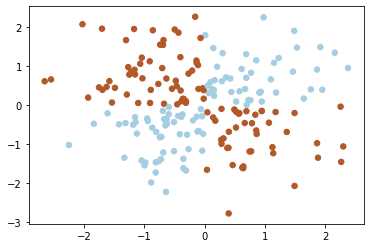

In [35]:
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired);

In [36]:
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
    clf.fit(X, y)
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

/home/dingo/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/home/dingo/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: The following kwargs were not used by contour: 'linetypes'
  if sys.path[0] == '':


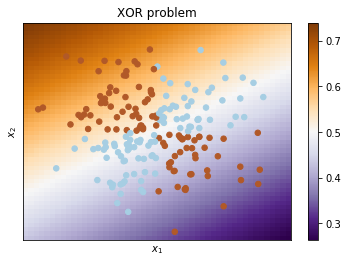

In [37]:
plot_boundary(LogisticRegression(), X, y,'XOR problem');

In [38]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logit', LogisticRegression())])

/home/dingo/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':
/home/dingo/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: The following kwargs were not used by contour: 'linetypes'
  if sys.path[0] == '':


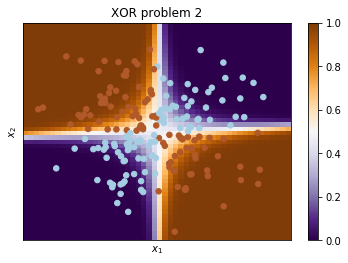

In [40]:
plot_boundary(logit_pipe, X, y, 'XOR problem 2');